In [1]:
import torch
from torch.autograd.functional import hessian
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
from aeons.covariance import X_mu, X_Sigmainv, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import linear, quad, simple, middle, full, ax_b
from models import LS, CG

Goal - find fraction $\alpha$ of $n_\text{dead}$ to us which maximises the evidence


**Thoughts:**

What if model is poor for the live points?

What do we want the optimal bandwidth to achieve? 

Adding a penalty makes it so that we use as many points as possible, *provided* that the fit isn't too bad. How do we judge "not too bad"?

What if logL vs X is concave - unlikely to happen in practice, since assumed that peaks are sharp. Look at plik samples again.

### **Toy model**

NS models fall on a sliding scale between two cases:

**(1)** Good model (low noise):
- More points = more evidence
- Good model means cost always small, evidence is dominated by increase in $\sigma$, N term

**(2)** Bad model OR high noise:
- More points = less evidence
- Cost blows up for more N because of bad fit, evidence dominated by this rather than $\sigma$, N term



If data is noisy - use more points. *Bandwidth should try to tackle cases where model is bad for some dead points, but good for the live points*

Always want the model to be good for the live points. What if this isn't the case?

In [2]:
def linear_noisy(x, m, sigma):
    noise = np.random.normal(0, sigma, len(x))
    return m * x + noise

def quad_noisy(x, m, sigma):
    noise = np.random.normal(0, sigma, len(x))
    return m * x**2 + noise

def minimise_m(y, x, m0):
    def func(m):
        return y - linear.func(x, m)
    return least_squares(func, m0)

def logPr_m(y, x, m, sigma):
    N = len(y)
    loss = y - linear.func(x, m)
    L_sq = np.sum(loss**2)
    return -0.5 * N * np.log(2*np.pi*sigma**2) - L_sq/(2*sigma**2)

def hess_m(y, x, m_max, sigma):
    N = len(y)
    y = torch.from_numpy(y)
    x = torch.from_numpy(x)
    theta_max = torch.tensor([*m_max, sigma], requires_grad=True)
    def func(theta):
        m, sigma = theta
        loss = y - linear.func(x, m)
        L_sq = torch.sum(loss**2)
        return -0.5 * N * torch.log(2*np.pi*sigma**2) - L_sq/(2*sigma**2)
    H = hessian(func, theta_max)
    return np.array(H)

def logZ(logPmax, H, D):
    return logPmax - 1/2 * np.log(abs(np.linalg.det(H))) + D/2 * np.log(2*np.pi)

def avg_evidence(y, x, m_true, sigma, repeats=5):
    evidences = []
    for i in range(repeats):
        y = linear_noisy(x, m_true, sigma)
        m = minimise_m(y, x, 10).x
        logPr_max_m = logPr_m(y, x, m, sigma)
        H = hess_m(y, x, m, sigma)
        evidence = logZ(logPr_max_m, H, D=2)
        evidences.append(evidence)
    return np.mean(evidences)

##### High vs low noise

In [3]:
m_true = 10
sigma = 0.1

x = np.linspace(0, 10, 10)
y = linear_noisy(x, m_true, sigma)

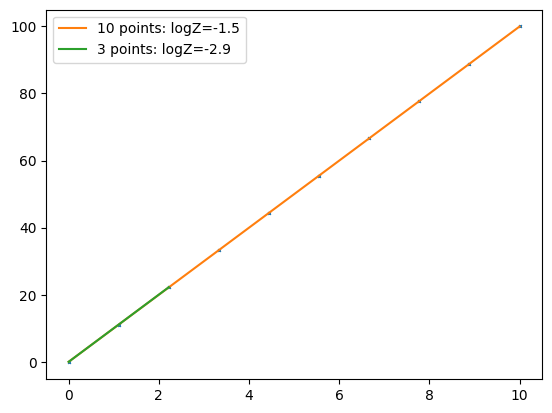

In [4]:
end = 3
xf = x[:end]
yf = y[:end]
mf = minimise_m(yf, xf, 10).x
m = minimise_m(y, x, 10).x
logPr_max_m = logPr_m(y, x, m, sigma)
H = hess_m(y, x, m, sigma)
evidence = logZ(logPr_max_m, H, D=2)

logPr_max_mf = logPr_m(yf, xf, mf, sigma)
Hf = hess_m(yf, xf, mf, sigma)
evidence_f = logZ(logPr_max_mf, Hf, D=2)

plt.plot(x, y, 'x', ms=2);
plt.plot(x, linear.func(x, m), label=f'10 points: logZ={evidence:.1f}');
plt.plot(xf, linear.func(xf, mf), label=f'3 points: logZ={evidence_f:.1f}');
plt.legend();

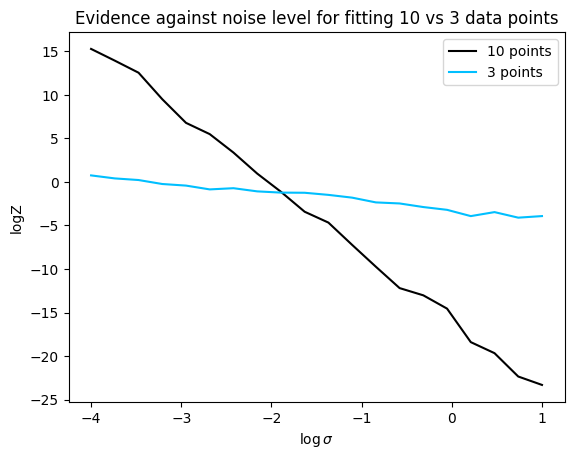

In [5]:
noise_level = np.exp(np.linspace(-4, 1, 20))
evidence_full = np.zeros_like(noise_level)
evidence_partial = np.zeros_like(noise_level)
for i, sigma in enumerate(noise_level):
    y = linear_noisy(x, m_true, sigma)
    yf = y[:end]
    evidence_full[i] = avg_evidence(y, x, m_true, sigma, repeats=20)
    evidence_partial[i] = avg_evidence(yf, xf, m_true, sigma, repeats=20)
plt.plot(np.log(noise_level), evidence_full, color='black', label='10 points')
plt.plot(np.log(noise_level), evidence_partial, color='deepskyblue', label='3 points');
plt.xlabel(r"$\log \sigma$")
plt.ylabel("logZ");
plt.legend();
plt.title("Evidence against noise level for fitting 10 vs 3 data points");

##### Low noise, bad model

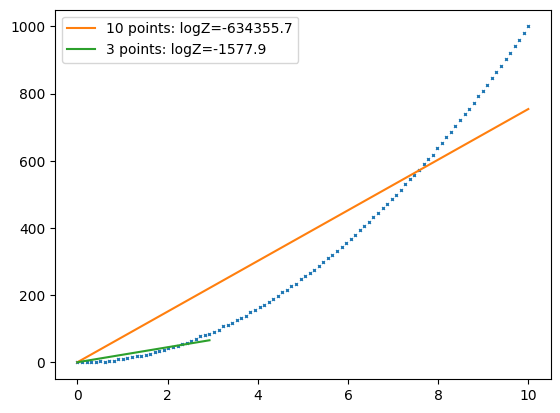

In [6]:
m_true = 10
sigma = 1

x = np.linspace(0, 10, 100)
y = quad_noisy(x, m_true, sigma)

end = 30
xf = x[:end]
yf = y[:end]
mf = minimise_m(yf, xf, 10).x
m = minimise_m(y, x, 10).x
logPr_max_m = logPr_m(y, x, m, sigma)
H = hess_m(y, x, m, sigma)
evidence = logZ(logPr_max_m, H, D=2)

logPr_max_mf = logPr_m(yf, xf, mf, sigma)
Hf = hess_m(yf, xf, mf, sigma)
evidence_f = logZ(logPr_max_mf, Hf, D=2)

plt.plot(x, y, 'x', ms=2);
plt.plot(x, linear.func(x, m), label=f'10 points: logZ={evidence:.1f}');
plt.plot(xf, linear.func(xf, mf), label=f'3 points: logZ={evidence_f:.1f}');
plt.legend();

### **Gaussian - good model, low noise**
Few things:
- logL plotted against mean, because this is what least squares thinks it's trying to fit - see how successful it is at its goal. Can also plot against true X values

- Model is still a good fit to data for large number of points. More evidence for more data **before** introducing penalty for fewer points
- Suggests we should use all of the data. If we introduce the evidence penalty for using few points, we would get the same conclusion.

$\log Z$ monotonically increases with $N$; $\alpha_\mathrm{max} = 1$

In [24]:
nlive, ndead = 500, 500
nk = nk_dead_live(nlive=500, ndead=500)
mean = X_mu(nk)

In [25]:
X = generate_Xs(nk)
theta_true = 10
like = simple
y = like.func(X, theta_true)
ls = LS(y, like, mean)
theta_l = ls.minimise(10)
logZ_l = ls.logZ(theta_l)

In [26]:
from ipywidgets import interact, FloatSlider
@interact(alpha=FloatSlider(min=0, max=1, step=0.1))
def func(alpha):
    # alpha = 0
    startf = int(ndead * (1 - alpha))
    Xf = X[startf:]
    yf = y[startf:]
    meanf = mean[startf:]
    lsf = LS(yf, like, meanf)

    theta_lf = lsf.minimise(10)
    logZ_lf = lsf.logZ(theta_lf)
    # plt.figure(figsize=(6,6))
    plt.plot(like.inverse(y, theta_l), y, label=f'all: logZ={logZ_l:.0f}, θ={np.round(theta_l, 2)}', lw=2, color='black')
    plt.plot(like.inverse(y, theta_lf), y, label=f'partial: logZ={logZ_lf:.0f}, θ={np.round(theta_lf, 2)}', lw=2, color='darkgoldenrod')
    # plt.plot(mean, y, 'x', ms=1, color='dimgray')
    # plt.plot(meanf, yf, 'x', ms=1, color='orange')
    plt.plot(X, y, 'x', ms=1, color='dimgray')
    plt.plot(Xf, yf, 'x', ms=1, color='orange')
    plt.xlim(0, 1)
    plt.legend();

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

### **Cauchy - okay model, low noise**

Model still good enough that using more data gathers more evidence

$\alpha_\mathrm{max} = 1$

In [27]:
def cauchy(X, theta=.1):
    return np.log(theta/(theta**2 + X**2))
ndead, nlive = 500, 500
nk = nk_dead_live(500, 500)
mean = X_mu(nk)

In [28]:
X = generate_Xs(nk)
y = cauchy(X, 0.1)
like = full
ls = LS(y, like, mean)

In [29]:
from ipywidgets import interact, FloatSlider
@interact(alpha=FloatSlider(min=0, max=1, step=0.1))
def func(alpha):
    # alpha = 0
    startf = int(ndead * (1 - alpha))
    Nex = startf
    penalty = Nex * np.log(Nex) - Nex if Nex != 0 else 0
    Xf = X[startf:]
    yf = y[startf:]
    meanf = mean[startf:]
    lsf = LS(yf, like, meanf)

    theta_l = ls.minimise([3, 11, 0.1])
    theta_lf = lsf.minimise([3, 10, 0.1])
    logZ_l = ls.logZ(theta_l)
    logZ_lf = lsf.logZ(theta_lf) - penalty
    # plt.figure(figsize=(6,6))
    plt.plot(like.inverse(y, theta_l), y, label=f'all: logZ={logZ_l:.0f}, θ={np.round(theta_l, 2)}', lw=2, color='black')
    plt.plot(like.inverse(y, theta_lf), y, label=f'partial: logZ={logZ_lf:.0f}, θ={np.round(theta_lf, 2)}', lw=2, color='darkgoldenrod')
    # plt.plot(mean, y, 'x', ms=1, color='dimgray')
    # plt.plot(meanf, yf, 'x', ms=1, color='orange')
    plt.plot(X, y, 'x', ms=1, color='dimgray')
    plt.plot(Xf, yf, 'x', ms=1, color='orange')
    plt.xlim(0, 1)
    plt.legend();

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

Bad model has less evidence e.g. linear worse than Gaussian

logPr_max: 2963.516202748015, Hessian: -24.559355683818673
logPr_max: 1227.3908817537954, Hessian: -14.0407829084373


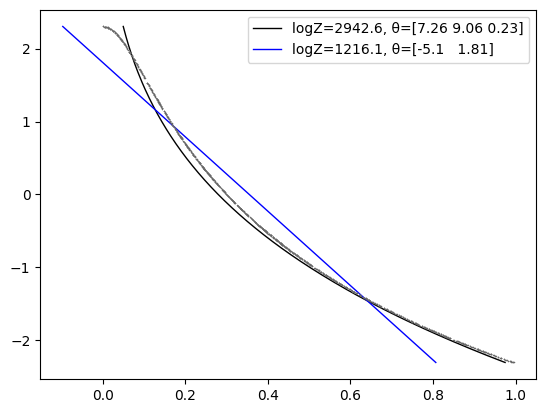

In [13]:
X = generate_Xs(nk)
y = cauchy(X, 0.1)
ls = LS(y, full, mean)
lsb = LS(y, ax_b, mean)
theta_b = lsb.minimise([-8, 5])
theta_l = ls.minimise([6, 10, 0.1])
logZ_l = ls.logZ(theta_l, details=True)
logZ_b = lsb.logZ(theta_b, details=True)

plt.plot(full.inverse(y, theta_l), y, label=f'logZ={logZ_l:.1f}, θ={np.round(theta_l, 2)}', lw=1, color='black')
plt.plot(ax_b.inverse(y, theta_b), y, label=f'logZ={logZ_b:.1f}, θ={np.round(theta_b, 2)}', lw=1, color='blue')
plt.plot(X, y, 'x', ms=.5, color='dimgray')
plt.legend();

### **Wedding cake - bad model and high noise**

Evidences more like case (2), even more so compared to Cauchy. What do we actually want to achieve with the bandwidth? 

What would be the ideal points/results to get here?

$\alpha_\mathrm{max} = 1$ 

In [30]:
def simple_step(X, theta, steps=10):
    return -np.floor(X**(2/theta) * steps)/steps
nlive, ndead = 500, 500
nk = nk_dead_live(nlive, ndead)
mean = X_mu(nk)

In [31]:
X = generate_Xs(nk)
y = simple_step(X, 10, steps=10)
like = full
ls = LS(y, like, mean)

In [32]:
from ipywidgets import interact, FloatSlider
@interact(alpha=FloatSlider(min=0, max=1, step=0.1))
def func(alpha):
    # alpha = 0
    startf = int(ndead * (1 - alpha))
    Nex = startf
    penalty = Nex * np.log(Nex) - Nex if Nex != 0 else 0
    Xf = X[startf:]
    yf = y[startf:]
    meanf = mean[startf:]
    lsf = LS(yf, like, meanf)

    theta_l = ls.minimise([0.2, 13, 0.5])
    theta_lf = lsf.minimise([1, 5, 1])
    logZ_l = ls.logZ(theta_l)
    logZ_lf = lsf.logZ(theta_lf) - penalty
    # plt.figure(figsize=(6,6))
    plt.plot(like.inverse(y, theta_l), y, label=f'all: logZ={logZ_l:.0f}, θ={np.round(theta_l, 2)}', lw=2, color='black')
    plt.plot(like.inverse(y, theta_lf), y, label=f'partial: logZ={logZ_lf:.0f}, θ={np.round(theta_lf, 2)}', lw=2, color='darkgoldenrod')
    # plt.plot(mean, y, 'x', ms=1, color='dimgray')
    # plt.plot(meanf, yf, 'x', ms=1, color='orange')
    plt.plot(X, y, 'x', ms=1, color='dimgray')
    plt.plot(Xf, yf, 'x', ms=1, color='orange')
    plt.xlim(0, 1)
    plt.legend();

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

### **Cubic - model good for live points, bad for some deads**

$\alpha_\mathrm{max} = 0.5/0.7$ without penalty, $0.65/0.8$ with

In [33]:
def cubic(X):
    return -(X-0.5)**3 - 0.1*X

nlive, ndead = 500, 500
nk = nk_dead_live(nlive, ndead)
mean = X_mu(nk)

In [34]:
X = generate_Xs(nk)
y = cubic(X)
like = full

In [35]:
from ipywidgets import interact, FloatSlider
@interact(alpha=FloatSlider(min=0, max=1, step=0.05))
def func(alpha):
    ls = LS(y, like, mean)
    # alpha = 0
    startf = int(ndead * (1 - alpha))
    Nex = startf
    penalty = Nex * np.log(Nex) - Nex if Nex != 0 else 0
    Xf = X[startf:]
    yf = y[startf:]
    meanf = mean[startf:]
    lsf = LS(yf, like, meanf)

    theta_l = ls.minimise([0.2, 3, 1.2])
    theta_lf = lsf.minimise([0.2, 3, 1.2])
    logZ_l = ls.logZ(theta_l)
    logZ_lf = lsf.logZ(theta_lf) - penalty
    # plt.figure(figsize=(6,6))
    plt.plot(like.inverse(y, theta_l), y, label=f'all: logZ={logZ_l:.0f}, θ={np.round(theta_l, 2)}', lw=2, color='black')
    plt.plot(like.inverse(y, theta_lf), y, label=f'partial: logZ={logZ_lf:.0f}, θ={np.round(theta_lf, 2)}', lw=2, color='darkgoldenrod')
    # plt.plot(mean, y, 'x', ms=1, color='dimgray')
    # plt.plot(meanf, yf, 'x', ms=1, color='orange')
    plt.plot(X, y, 'x', ms=1, color='dimgray')
    plt.plot(Xf, yf, 'x', ms=1, color='orange')
    plt.xlim(0, 1)
    plt.legend();

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

### **Gaussian NS chain**

$\log Z$ peaks at $\alpha = 0.9$ without penalty, 1 with (noise at start of the run fits model badly)

In [20]:
ndead = 1000
nlive = 500
samples = points_at_iteration(samples_g_1, ndead)
y = np.array(samples.logL)
mean = np.array(np.exp(samples.logX()))
like = full

In [21]:
from ipywidgets import interact, FloatSlider
@interact(alpha=FloatSlider(min=0, max=1, step=0.1))
def func(alpha):
    ls = LS(y, like, mean)
    # alpha = 0
    startf = int(ndead * (1 - alpha))
    Nex = startf
    penalty = Nex * np.log(Nex) - Nex if Nex != 0 else 0
    yf = y[startf:]
    meanf = mean[startf:]
    lsf = LS(yf, like, meanf)

    theta_l = ls.minimise([1, 10, 0.1])
    theta_lf = lsf.minimise([1, 10, 0.1])
    logZ_l = ls.logZ(theta_l)
    logZ_lf = lsf.logZ(theta_lf)# - penalty
    # plt.figure(figsize=(6,6))
    plt.plot(like.inverse(y, theta_l), y, label=f'all: logZ={logZ_l:.0f}, θ={np.round(theta_l, 2)}', lw=2, color='black')
    plt.plot(like.inverse(y, theta_lf), y, label=f'partial: logZ={logZ_lf:.0f}, θ={np.round(theta_lf, 2)}', lw=2, color='darkgoldenrod')
    plt.plot(mean, y, 'x', ms=1, color='dimgray')
    plt.plot(meanf, yf, 'x', ms=1, color='orange')
    plt.xlim(0, 1)
    plt.legend();

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

### **Correlated Gaussian NS chain**

$\alpha_\mathrm{max} = 0$ without penalty, $0.5-0.7$ with penalty

In [36]:
ndead = 1000
nlive = 500
samples = points_at_iteration(samples_c_1, ndead)
nk = np.array(samples.nlive)
y = np.array(samples.logL)
mean = np.array(np.exp(samples.logX()))
covinv = X_Sigmainv(nk)
like = full

In [37]:
from ipywidgets import interact, FloatSlider
@interact(alpha=FloatSlider(min=0, max=1, step=0.1))
def func(alpha):
    ls = LS(y, like, mean)
    # alpha = 0
    startf = int(ndead * (1 - alpha))
    Nex = startf
    penalty = Nex * np.log(Nex) - Nex if Nex != 0 else 0
    yf = y[startf:]
    meanf = mean[startf:]
    lsf = LS(yf, like, meanf)

    theta_l = ls.minimise([1, 10, 0.1])
    theta_lf = lsf.minimise([1, 10, 0.1])
    logZ_l = ls.logZ(theta_l)
    logZ_lf = lsf.logZ(theta_lf) - penalty
    # plt.figure(figsize=(6,6))
    plt.plot(like.inverse(y, theta_l), y, label=f'all: logZ={logZ_l:.0f}, θ={np.round(theta_l, 2)}', lw=2, color='black')
    plt.plot(like.inverse(y, theta_lf), y, label=f'partial: logZ={logZ_lf:.0f}, θ={np.round(theta_lf, 2)}', lw=2, color='darkgoldenrod')
    plt.plot(mean, y, 'x', ms=1, color='dimgray')
    plt.plot(meanf, yf, 'x', ms=1, color='orange')
    plt.xlim(0, 1)
    plt.legend();

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…

In [20]:
from ipywidgets import interact, FloatSlider
@interact(alpha=FloatSlider(min=0, max=1, step=0.1))
def func(alpha):
    cg = CG(y, like, mean, covinv)
    # alpha = 0
    startf = int(ndead * (1 - alpha))
    Nex = startf
    penalty = Nex * np.log(Nex) - Nex if Nex != 0 else 0
    yf = y[startf:]
    meanf = mean[startf:]
    cgf = CG(yf, like, meanf, covinv)

    theta_c = cg.minimise([1, 10, 0.1])
    theta_cf = cgf.minimise([1, 10, 0.1])
    logZ_c = cg.logZ(theta_c)
    logZ_cf = cgf.logZ(theta_cf)# - penalty
    # plt.figure(figsize=(6,6))
    plt.plot(like.inverse(y, theta_c), y, label=f'all: logZ={logZ_c:.0f}, θ={np.round(theta_c, 2)}', lw=2, color='black')
    plt.plot(like.inverse(y, theta_cf), y, label=f'partial: logZ={logZ_cf:.0f}, θ={np.round(theta_cf, 2)}', lw=2, color='darkgoldenrod')
    plt.plot(mean, y, 'x', ms=1, color='dimgray')
    plt.plot(meanf, yf, 'x', ms=1, color='orange')
    plt.xlim(0, 1)
    plt.legend();

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0), Output()), _dom_classes=('widget-i…